In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init

import random

import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from src.CPPN1 import CPPN1training
from sklearn.model_selection import train_test_split

In [2]:
# wandb.init(project="CPPNsquared")

#### Hyperparameters

In [3]:
device = 'cuda'
num_steps = 40000
batch_size = 128
learn_rate = 0.001
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [4]:
cppn1 = CPPN1()
cppn1.load_state_dict = torch.load('Checkpoints/CPPN64.pt')
print(cppn1)
# feature maps trasfer learning 

CPPN1(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [5]:
print(len(list(cppn1.children())))

4


In [6]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

In [7]:
for name, param in cppn1.named_parameters():
    print(name)

fc1.weight
fc1.bias
fc2.weight
fc2.bias
fce1.weight
fce1.bias
fc3.weight
fc3.bias


#### Map spacial coordinates

In [8]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []
layer_count = len(list(cppn1.children()))


def normalize(tensor, axis):
    if axis % 2 == 0:
        max_vals = layer_count
        min_vals = 0
    else:
        max_vals, _ = torch.max(tensor, dim=0)
        min_vals, _ = torch.min(tensor, dim=0)

    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

def spatial_coords(array, layer):

    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in cppn1.named_parameters():
    
    # print(name)
    if name.endswith("fc1.weight"):
        
        # print(index)
        # print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, index)
        temp_coords = torch.tensor(temp_coords, device=device, dtype=torch.float32)
        normal = temp_coords
        print(temp_coords)
        for i in range(4):
            # print(i)
            normal[:,i] = normalize(temp_coords[:, i], i)
            # normal = torch.nan_to_num(normal, nan = 0)
        if index == 3:
            # print(temp_coords)
            print(normal)
            # print(normal)
        full_coords.extend(normal.tolist())
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)

# print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

        

tensor([[ 0.,  0.,  1.,  0.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  0.,  1.,  1.],
        [ 0.,  1.,  1.,  1.],
        [ 0.,  0.,  1.,  2.],
        [ 0.,  1.,  1.,  2.],
        [ 0.,  0.,  1.,  3.],
        [ 0.,  1.,  1.,  3.],
        [ 0.,  0.,  1.,  4.],
        [ 0.,  1.,  1.,  4.],
        [ 0.,  0.,  1.,  5.],
        [ 0.,  1.,  1.,  5.],
        [ 0.,  0.,  1.,  6.],
        [ 0.,  1.,  1.,  6.],
        [ 0.,  0.,  1.,  7.],
        [ 0.,  1.,  1.,  7.],
        [ 0.,  0.,  1.,  8.],
        [ 0.,  1.,  1.,  8.],
        [ 0.,  0.,  1.,  9.],
        [ 0.,  1.,  1.,  9.],
        [ 0.,  0.,  1., 10.],
        [ 0.,  1.,  1., 10.],
        [ 0.,  0.,  1., 11.],
        [ 0.,  1.,  1., 11.],
        [ 0.,  0.,  1., 12.],
        [ 0.,  1.,  1., 12.],
        [ 0.,  0.,  1., 13.],
        [ 0.,  1.,  1., 13.],
        [ 0.,  0.,  1., 14.],
        [ 0.,  1.,  1., 14.],
        [ 0.,  0.,  1., 15.],
        [ 0.,  1.,  1., 15.],
        [ 0.,  0.,  1., 16.],
        [ 

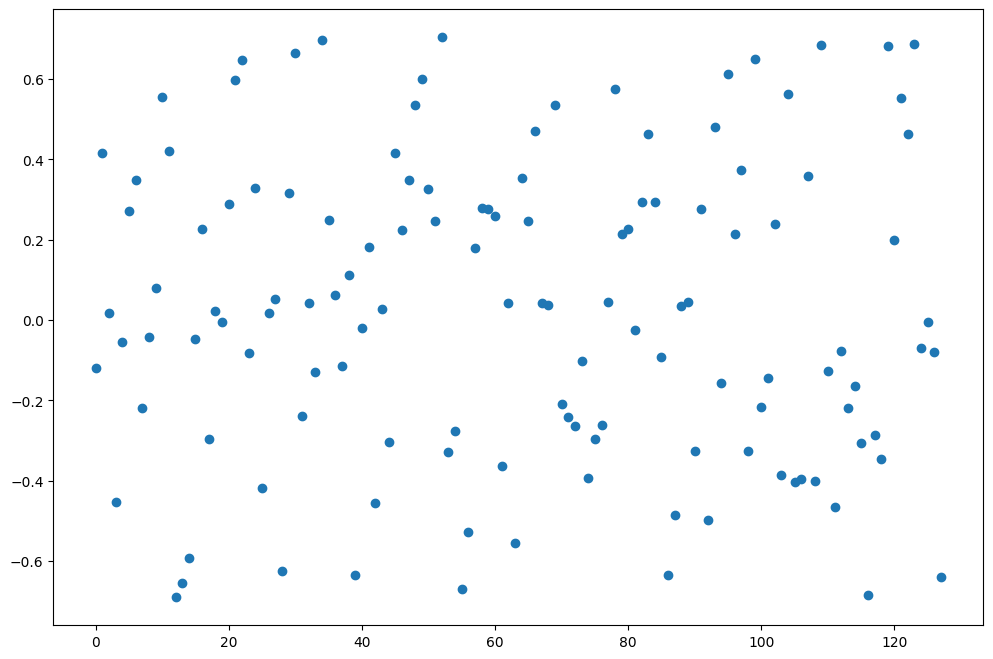

In [9]:
fig, ax = plt.subplots(figsize =(12,8))
ax.scatter(range(len(full_weights)), full_weights)

#### Set up CPPN_squared

In [10]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 16)

      self.fc2 = nn.Linear(16, 16)
      self.fce1 = nn.Linear(64, 64)
      self.fce2 = nn.Linear(64,64)

      self.fc3 = nn.Linear(16, 1)     

    #   self.init_weights()
      
    # def init_weights(self):
    #   for m in self.modules():
    #       if isinstance(m, nn.Linear):
    #           # Initialize weights using Xavier initialization
    #           init.xavier_normal_(m.weight)
    #           # Initialize biases to zeros
    #           init.constant_(m.bias, 0)
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        # x = torch.sin(x)
        # x = F.relu(x)
        x = F.tanh(x)

        # x = self.fc2(x)
        # x = torch.sin(x)
        # x = F.relu(x)

        # x = self.fce1(x)
        # x = F.relu(x)

        # x = self.fce2(x)
        # x = F.relu(x)

        x = self.fc3(x)
        # x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [11]:
CPPN_squared = CPPN_squared()
# wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)



criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction = "mean")
# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization

In [12]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [13]:
normalized_coords_matrix = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
# normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
# print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
# all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([0.4406, 0.7078, 0.5091, 0.2730, 0.4726, 0.6362, 0.6737, 0.3903, 0.4785,
        0.5394, 0.7769, 0.7106, 0.1549, 0.1725, 0.2034, 0.4766, 0.6133, 0.3521,
        0.5117, 0.4974, 0.6450, 0.7984, 0.8239, 0.4589, 0.6638, 0.2909, 0.5087,
        0.5257, 0.1882, 0.6577, 0.8322, 0.3800, 0.5210, 0.4349, 0.8483, 0.6245,
        0.5315, 0.4428, 0.5559, 0.1821, 0.4905, 0.5907, 0.2718, 0.5138, 0.3477,
        0.7078, 0.6116, 0.6741, 0.7677, 0.7997, 0.6631, 0.6226, 0.8519, 0.3360,
        0.3614, 0.1651, 0.2356, 0.5902, 0.6399, 0.6382, 0.6300, 0.3186, 0.5208,
        0.2227, 0.6763, 0.6237, 0.7353, 0.5206, 0.5189, 0.7682, 0.3961, 0.3798,
        0.3684, 0.4493, 0.3029, 0.3524, 0.3692, 0.5218, 0.7880, 0.6072, 0.6136,
        0.4876, 0.6463, 0.7314, 0.6469, 0.4536, 0.1831, 0.2574, 0.5170, 0.5221,
        0.3371, 0.6380, 0.2513, 0.7407, 0.4218, 0.8066, 0.6070, 0.6868, 0.3373,
        0.8248, 0.3917, 0.4277, 0.6195, 0.3071, 0.7808, 0.2988, 0.3021, 0.6788,
        0.2992, 0.8428, 0.4362, 0.2671, 

#### Split training and validation set


In [14]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.1, random_state=42)
# import math
batch_size = int(batch_size * 0.9)

In [15]:
print(normalized_coords_matrix)

tensor([[-1.0000, -1.0000, -0.5000, -1.0000],
        [-1.0000,  1.0000, -0.5000, -1.0000],
        [-1.0000, -1.0000, -0.5000, -0.9683],
        [-1.0000,  1.0000, -0.5000, -0.9683],
        [-1.0000, -1.0000, -0.5000, -0.9365],
        [-1.0000,  1.0000, -0.5000, -0.9365],
        [-1.0000, -1.0000, -0.5000, -0.9048],
        [-1.0000,  1.0000, -0.5000, -0.9048],
        [-1.0000, -1.0000, -0.5000, -0.8730],
        [-1.0000,  1.0000, -0.5000, -0.8730],
        [-1.0000, -1.0000, -0.5000, -0.8413],
        [-1.0000,  1.0000, -0.5000, -0.8413],
        [-1.0000, -1.0000, -0.5000, -0.8095],
        [-1.0000,  1.0000, -0.5000, -0.8095],
        [-1.0000, -1.0000, -0.5000, -0.7778],
        [-1.0000,  1.0000, -0.5000, -0.7778],
        [-1.0000, -1.0000, -0.5000, -0.7460],
        [-1.0000,  1.0000, -0.5000, -0.7460],
        [-1.0000, -1.0000, -0.5000, -0.7143],
        [-1.0000,  1.0000, -0.5000, -0.7143],
        [-1.0000, -1.0000, -0.5000, -0.6825],
        [-1.0000,  1.0000, -0.5000

In [16]:
num_coords = normalized_coords_matrix.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000

# training loop
for i in range(num_steps):
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    # Sample a random batch of indexes from the list coord_indexes
    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, train_coords.shape[0]), batch_size)))
    
    # Get batch of respective xy_coordiantes
    training_coords_batch = normalized_coords_matrix[training_batch_indexes]
    
    # And respective pixel values 
    pixel_values_batch = train_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)
    
    # Process data with model
    approx_pixel_values = CPPN_squared(training_coords_batch)
    
    # Calculate and track loss function
    loss = criterion(approx_pixel_values, pixel_values_batch)
    running_loss += loss.item()
    losses.append(loss.item())
    
    if i % 1 == 0:
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(CPPN_squared.state_dict(), 'Checkpoints/CPPN2model.pt')
        print(f'step {i}, loss {running_loss:.3f}')
        # wandb.log({"loss": loss.item()})
        running_loss = 0.0

        #validation loop
        with torch.no_grad():
            val_loss = 0.0
            #should i iterate through them one by one or just do the whole thing?
            # for i in range(val_coords.shape[0]):
            #     val_output = CPPN_squared(val_coords[i])
            #     val_loss += criterion(val_pixel_values[i], val_output.unsqueeze(0)).item()
            val_output = CPPN_squared(val_coords)
            val_loss += criterion(val_output,val_pixel_values.unsqueeze(1)).item()
            # val_loss /= val_coords.shape[0]

            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     best_model_weights = CPPN_squared.state_dict()
            #     torch.save(best_model_weights, 'best_CPPN2_weights.pt')
                
            print(f'Validation - Step {i}, loss {val_loss:.3f}')
            # wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    # wandb.log({"final_weights": CPPN_squared.state_dict()})

step 0, loss 0.047
Validation - Step 0, loss 0.037
step 1, loss 0.046


Validation - Step 1, loss 0.037
step 2, loss 0.044
Validation - Step 2, loss 0.036
step 3, loss 0.043
Validation - Step 3, loss 0.036
step 4, loss 0.042
Validation - Step 4, loss 0.035
step 5, loss 0.041
Validation - Step 5, loss 0.035
step 6, loss 0.040
Validation - Step 6, loss 0.035
step 7, loss 0.040
Validation - Step 7, loss 0.035
step 8, loss 0.039
Validation - Step 8, loss 0.035
step 9, loss 0.039
Validation - Step 9, loss 0.035
step 10, loss 0.038
Validation - Step 10, loss 0.035
step 11, loss 0.038
Validation - Step 11, loss 0.035
step 12, loss 0.038
Validation - Step 12, loss 0.035
step 13, loss 0.037
Validation - Step 13, loss 0.036
step 14, loss 0.037
Validation - Step 14, loss 0.036
step 15, loss 0.037
Validation - Step 15, loss 0.036
step 16, loss 0.037
Validation - Step 16, loss 0.036
step 17, loss 0.037
Validation - Step 17, loss 0.036
step 18, loss 0.037
Validation - Step 18, loss 0.036
step 19, loss 0.037
Validation - Step 19, loss 0.036
step 20, loss 0.037
Validation

In [17]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction)

tensor([0.4454, 0.6068, 0.4492, 0.5648, 0.5794, 0.5119, 0.6346, 0.4591, 0.6298,
        0.4254, 0.6251, 0.4305, 0.6204, 0.4356, 0.6156, 0.4406, 0.6109, 0.4457,
        0.6061, 0.4508, 0.6014, 0.4559, 0.5967, 0.4610, 0.5919, 0.4661, 0.5872,
        0.4711, 0.5824, 0.4762, 0.5777, 0.4813, 0.5729, 0.4864, 0.5682, 0.4915,
        0.5635, 0.4966, 0.5587, 0.5016, 0.5540, 0.5067, 0.5492, 0.5118, 0.5445,
        0.5169, 0.5397, 0.5220, 0.5350, 0.5271, 0.5303, 0.5321, 0.5255, 0.5372,
        0.5208, 0.5423, 0.5189, 0.5474, 0.5175, 0.5519, 0.5162, 0.5478, 0.5148,
        0.5437, 0.5134, 0.5396, 0.5121, 0.5355, 0.5107, 0.5314, 0.5094, 0.5273,
        0.5080, 0.5232, 0.5067, 0.5191, 0.5053, 0.5150, 0.5040, 0.5109, 0.5026,
        0.5068, 0.5012, 0.5027, 0.4999, 0.4986, 0.4985, 0.4945, 0.4972, 0.4904,
        0.4958, 0.4863, 0.4945, 0.4822, 0.4931, 0.4782, 0.4917, 0.4741, 0.4904,
        0.4700, 0.4890, 0.4659, 0.4877, 0.4618, 0.4863, 0.4577, 0.4850, 0.4536,
        0.4836, 0.4495, 0.4823, 0.4454, 

In [18]:
print(all_pixel_values)

tensor([0.4406, 0.7078, 0.5091, 0.2730, 0.4726, 0.6362, 0.6737, 0.3903, 0.4785,
        0.5394, 0.7769, 0.7106, 0.1549, 0.1725, 0.2034, 0.4766, 0.6133, 0.3521,
        0.5117, 0.4974, 0.6450, 0.7984, 0.8239, 0.4589, 0.6638, 0.2909, 0.5087,
        0.5257, 0.1882, 0.6577, 0.8322, 0.3800, 0.5210, 0.4349, 0.8483, 0.6245,
        0.5315, 0.4428, 0.5559, 0.1821, 0.4905, 0.5907, 0.2718, 0.5138, 0.3477,
        0.7078, 0.6116, 0.6741, 0.7677, 0.7997, 0.6631, 0.6226, 0.8519, 0.3360,
        0.3614, 0.1651, 0.2356, 0.5902, 0.6399, 0.6382, 0.6300, 0.3186, 0.5208,
        0.2227, 0.6763, 0.6237, 0.7353, 0.5206, 0.5189, 0.7682, 0.3961, 0.3798,
        0.3684, 0.4493, 0.3029, 0.3524, 0.3692, 0.5218, 0.7880, 0.6072, 0.6136,
        0.4876, 0.6463, 0.7314, 0.6469, 0.4536, 0.1831, 0.2574, 0.5170, 0.5221,
        0.3371, 0.6380, 0.2513, 0.7407, 0.4218, 0.8066, 0.6070, 0.6868, 0.3373,
        0.8248, 0.3917, 0.4277, 0.6195, 0.3071, 0.7808, 0.2988, 0.3021, 0.6788,
        0.2992, 0.8428, 0.4362, 0.2671, 

Text(0.5, 1.0, 'target')

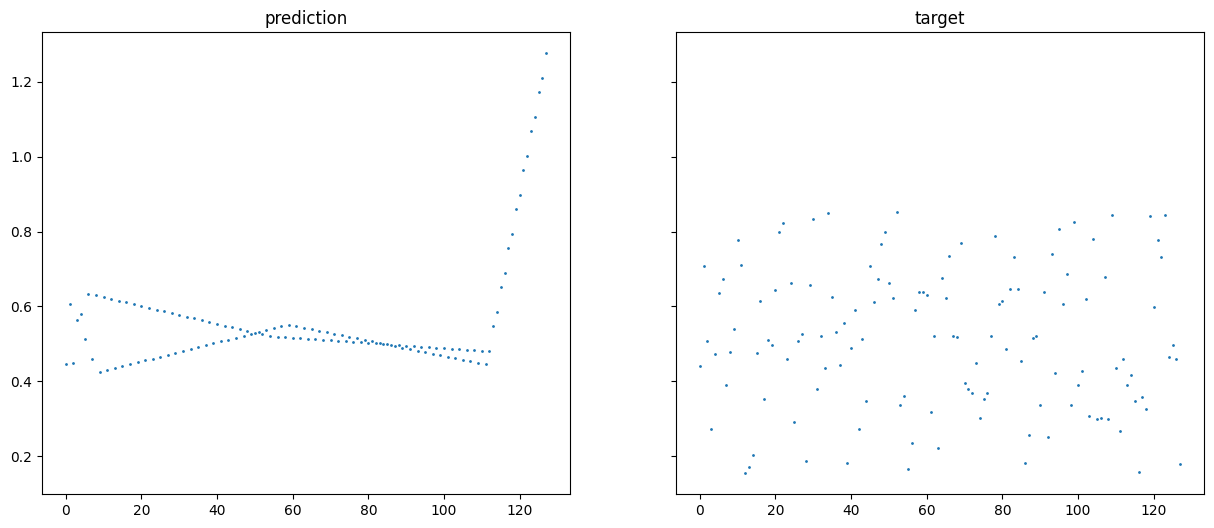

In [19]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
# ax[0].set_ylim([0.1, 0.9])
x_values = np.arange(len(prediction.cpu().numpy()))

ax[0].scatter(x_values, prediction.cpu().numpy(), marker='o', s=1)
ax[0].set_title("prediction")
ax[1].scatter(x_values, all_pixel_values.cpu().numpy(), marker='o', s=1)
ax[1].set_title("target")

In [20]:
# prediction.mul_(2).sub_(1)

index_tracker = 0
with torch.no_grad():
    for name, param in cppn1.named_parameters():
        # print(name)
        if name.endswith("fc1.weight"):
            # print(param) 
            # prediction.mul_()
            temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
            print(param.numel())
            temp_tensor = torch.reshape(temp_tensor, param.shape)
            print(temp_tensor)
            param.data.copy_(temp_tensor)
            # print(param.numel())
            index_tracker += param.numel()
    
            print(f"{name} replacement complete")

    torch.save(cppn1.state_dict(), "Checkpoints/CPPNsquared_output.pt")

128
tensor([[-1.0919e-01,  2.1365e-01],
        [-1.0163e-01,  1.2953e-01],
        [ 1.5884e-01,  2.3827e-02],
        [ 2.6917e-01, -8.1874e-02],
        [ 2.5969e-01, -1.4921e-01],
        [ 2.5021e-01, -1.3904e-01],
        [ 2.4072e-01, -1.2888e-01],
        [ 2.3124e-01, -1.1871e-01],
        [ 2.2175e-01, -1.0854e-01],
        [ 2.1227e-01, -9.8375e-02],
        [ 2.0278e-01, -8.8207e-02],
        [ 1.9330e-01, -7.8041e-02],
        [ 1.8382e-01, -6.7873e-02],
        [ 1.7433e-01, -5.7706e-02],
        [ 1.6485e-01, -4.7539e-02],
        [ 1.5536e-01, -3.7372e-02],
        [ 1.4588e-01, -2.7205e-02],
        [ 1.3640e-01, -1.7038e-02],
        [ 1.2691e-01, -6.8709e-03],
        [ 1.1743e-01,  3.2961e-03],
        [ 1.0794e-01,  1.3462e-02],
        [ 9.8458e-02,  2.3630e-02],
        [ 8.8974e-02,  3.3797e-02],
        [ 7.9490e-02,  4.3964e-02],
        [ 7.0006e-02,  5.4132e-02],
        [ 6.0521e-02,  6.4299e-02],
        [ 5.1038e-02,  7.4466e-02],
        [ 4.1552e-02,  8